In [1]:
import os
import pandas as pd

from pprint import pprint

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR

from pytorch_lightning import LightningModule, Trainer, seed_everything

from transformers import BertForSequenceClassification, BertTokenizer, AdamW

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import re
import emoji
from soynlp.normalizer import repeat_normalize

In [2]:
device = torch.device("cuda:0")

In [3]:
MODEL_NAME= "beomi/kcbert-base"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [4]:
import pandas as pd
data_path ='C:/Users/USER/Desktop/2021_korean_hate_speech_detection/hs_CORAL/dataset/'
koco_train_df = pd.read_csv(data_path+"koco_hate_train.txt", sep="\t")
koco_test_df = pd.read_csv(data_path+"koco_hate_test.txt", sep="\t")
koco_train_df.head(5)

,comments,hate
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,2
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,0
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",2
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",0
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,2


In [5]:
tokenized_train_sentences = tokenizer(
                            list(koco_train_df['comments']),
                            return_tensors="pt",
                            max_length=64,
                            padding=True,
                            truncation=True,
                            add_special_tokens=True)

tokenized_test_sentences = tokenizer(
                            list(koco_test_df['comments']),
                            return_tensors="pt",
                            max_length=64,
                            padding=True,
                            truncation=True,
                            add_special_tokens=True)

In [6]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

In [7]:
train_label = koco_train_df["hate"].values
test_label =  koco_test_df["hate"].values

train_dataset = MyDataset(tokenized_train_sentences, train_label)
test_dataset = MyDataset(tokenized_test_sentences, test_label)

# 모델 튜닝

In [8]:
from coral_pytorch.layers import CoralLayer
from coral_pytorch.losses import CoralLoss
from coral_pytorch.dataset import levels_from_labelbatch
from coral_pytorch.dataset import proba_to_label
from coral_pytorch.losses import corn_loss
from typing import Optional

In [9]:
from transformers.modeling_outputs import SequenceClassifierOutput

In [10]:
from transformers import BertPreTrainedModel, BertModel
import torch.nn as nn
class BertForSequenceClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        self.bert = BertModel(config)
        classifier_dropout = 0.2
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels-1)
        
        #self.coral_layer = CoralLayer(config.hidden_size, config.num_labels)
        # Initialize weights and apply final processing

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ):
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        #logits = self.coral_layer(pooled_output)
#         self.probas1 = torch.sigmoid(logits)
#         self.probas = torch.cumprod(self.probas1, dim=1)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
            elif self.config.problem_type == 'CORAL':
                #loss_fct = CoralLoss()
                #levels = levels_from_labelbatch(labels.view(-1) , num_classes=3).to(device)
                #loss = loss_fct(logits, levels)
                loss = corn_loss(logits, labels, self.config.num_labels)
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [11]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from coral_pytorch.dataset import corn_label_from_logits

def compute_metrics(pred):
    labels = pred.label_ids
    predicts = pred.predictions
    preds = corn_label_from_logits(torch.tensor(predicts))
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [12]:
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, 
                                                      num_labels=3,
                                                      problem_type='CORAL')

Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initiali

In [13]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir='C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_CORN_outputs/output/', # 학습결과 저장경로
    num_train_epochs=10,                # 학습 epoch 설정
    per_device_train_batch_size=4,      # train batch_size 설정
    per_device_eval_batch_size=32,      # test batch_size 설정
    logging_dir='C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_CORN_outputs/logs/',# 학습log 저장경로
    logging_steps=500,                  # 학습log 기록 단위
    save_total_limit=2,                 # 학습결과 저장 최대갯수 
)

In [14]:
from transformers import Trainer
#model.load_state_dict(torch.load('KcBERT_CORN_outputs/output/pytorch_model.bin'))
trainer = Trainer(
    model=model,                         # 학습하고자하는 🤗 Transformers model
    args=training_args,                  # 위에서 정의한 Training Arguments
    train_dataset=train_dataset,         # 학습 데이터셋
    eval_dataset=test_dataset,           # 평가 데이터셋
    compute_metrics=compute_metrics,     # 평가지표
)

In [15]:
trainer.train()

***** Running training *****
  Num examples = 7896
  Num Epochs = 10
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 19740
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step,Training Loss
500,0.611600
1000,0.605600
1500,0.595500
2000,0.587100
2500,0.511500
3000,0.498800
3500,0.535800
4000,0.508100
4500,0.470700
5000,0.487300


Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_CORN_outputs/output/checkpoint-500
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_CORN_outputs/output/checkpoint-500\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_CORN_outputs/output/checkpoint-500\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KcBERT_CORN_outputs\output\checkpoint-19000] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_CORN_outputs/output/checkpoint-1000
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_CORN_outputs/output/checkp

Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KcBERT_CORN_outputs\output\checkpoint-4500] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_CORN_outputs/output/checkpoint-6000
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_CORN_outputs/output/checkpoint-6000\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_CORN_outputs/output/checkpoint-6000\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KcBERT_CORN_outputs\output\checkpoint-5000] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\i

Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_CORN_outputs/output/checkpoint-11000
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_CORN_outputs/output/checkpoint-11000\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_CORN_outputs/output/checkpoint-11000\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KcBERT_CORN_outputs\output\checkpoint-10000] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_CORN_outputs/output/checkpoint-11500
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_CORN_outputs/output

Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_CORN_outputs/output/checkpoint-16000\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KcBERT_CORN_outputs\output\checkpoint-15000] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_CORN_outputs/output/checkpoint-16500
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_CORN_outputs/output/checkpoint-16500\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_CORN_outputs/output/checkpoint-16500\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KcBERT_C

TrainOutput(global_step=19740, training_loss=0.36895295020415547, metrics={'train_runtime': 1434.2684, 'train_samples_per_second': 55.052, 'train_steps_per_second': 13.763, 'total_flos': 2596906116403200.0, 'train_loss': 0.36895295020415547, 'epoch': 10.0})

In [16]:
trainer.evaluate(eval_dataset=test_dataset)

***** Running Evaluation *****
  Num examples = 471
  Batch size = 32
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


{'eval_loss': 1.091366171836853,
 'eval_accuracy': 0.6348195329087049,
 'eval_f1': 0.6377932116830745,
 'eval_precision': 0.6570620692813152,
 'eval_recall': 0.6376619105444242,
 'eval_runtime': 0.4448,
 'eval_samples_per_second': 1058.8,
 'eval_steps_per_second': 33.72,
 'epoch': 10.0}

In [17]:
trainer.save_model()

Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_CORN_outputs/output/
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_CORN_outputs/output/config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_CORN_outputs/output/pytorch_model.bin


In [18]:
predictions = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 471
  Batch size = 32
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [19]:
predictions

PredictionOutput(predictions=array([[0.01196167, 0.00279913],
       [0.9987545 , 0.00366343],
       [0.99886715, 0.00459284],
       [0.9988626 , 0.00653753],
       [0.9982925 , 0.0023647 ],
       [0.9972818 , 0.98211086],
       [0.01196181, 0.00279925],
       [0.01196158, 0.00279907],
       [0.01196646, 0.00279931],
       [0.9881052 , 0.0024444 ],
       [0.01196609, 0.00279915],
       [0.9988367 , 0.00422737],
       [0.01196127, 0.00279913],
       [0.9983139 , 0.00240705],
       [0.9964881 , 0.951866  ],
       [0.01198476, 0.00279908],
       [0.99881834, 0.00410454],
       [0.997282  , 0.9821103 ],
       [0.9987999 , 0.0039464 ],
       [0.9929872 , 0.00142527],
       [0.9984269 , 0.00258752],
       [0.9984744 , 0.00268117],
       [0.9987596 , 0.00368377],
       [0.9987447 , 0.00359177],
       [0.99659747, 0.00155426],
       [0.01196194, 0.00279924],
       [0.998825  , 0.0041474 ],
       [0.9972819 , 0.98211044],
       [0.01196667, 0.00279886],
       [0.9980

In [ ]:
def corn_label_from_logits(logits):
    #probas = torch.cumprod(logits, dim=1)
    #probas = logits
    probas = logits
    predict_levels = probas > 0.5
    predicted_labels = torch.sum(predict_levels, dim=1)
    return predicted_labels

              precision    recall  f1-score   support

           0       0.62      0.81      0.70       160
           1       0.58      0.52      0.55       189
           2       0.77      0.58      0.66       122

    accuracy                           0.63       471
   macro avg       0.66      0.64      0.64       471
weighted avg       0.64      0.63      0.63       471



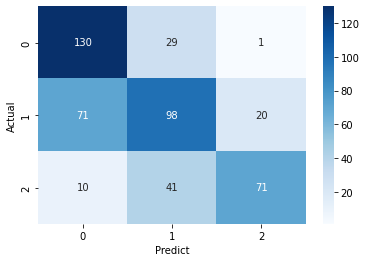

In [20]:

## classification_report
from sklearn.metrics import classification_report
y_test = test_dataset.labels
preds_list = corn_label_from_logits(torch.tensor(predictions.predictions))
clf_report = classification_report(y_test, preds_list)
print(clf_report)

# 오차행렬 생성
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(y_test, preds_list)

# 오차행렬 시각화
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [21]:
from coral_pytorch.dataset import proba_to_label

def compute_mae_and_mse(label, preds_list):

    mae, mse = 0., 0.
    num_examples = len(label)
    targets = torch.tensor(label)
    predicted_labels = torch.tensor(preds_list)
    
    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

    mae = mae / num_examples
    mse = mse / num_examples
    return mae, mse

In [22]:
mae, mse = compute_mae_and_mse(y_test, preds_list)
print(mae)
print(mse)

tensor(0.3885)
tensor(0.4352)


C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


# iw and threshold

In [13]:
from scipy import special
import pandas as pd

def custom_proba_to_label(probas, first_threshold, second_threshold):
    predict_levels = pd.DataFrame(probas)
    class_O = predict_levels[0].apply(lambda x: x > first_threshold)
    class_H = predict_levels[1].apply(lambda x: x > second_threshold)
    labels_v3 = pd.concat([class_O, class_H], axis=1)
    labels_v3 = labels_v3.sum(axis=1)
    return labels_v3

In [14]:
from transformers import BertPreTrainedModel, BertModel
import torch.nn as nn
class BertForSequenceClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        self.bert = BertModel(config)
        classifier_dropout = 0.2
        self.dropout = nn.Dropout(classifier_dropout)
        #self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        
        self.coral_layer = CoralLayer(config.hidden_size, config.num_labels)
        # Initialize weights and apply final processing

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ):
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        #logits = self.classifier(pooled_output)
        logits = self.coral_layer(pooled_output)
        probas = torch.sigmoid(logits)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
            elif self.config.problem_type == 'CORAL':
                iw = torch.tensor([1, 0.5]).to(device)
                loss_fct = CoralLoss()
                levels = levels_from_labelbatch(labels.view(-1) , num_classes=3).to(device)
                loss = loss_fct(logits, levels, importance_weights=iw)
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=probas,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [15]:
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, 
                                                      num_labels=3,
                                                      problem_type='CORAL')

Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initiali

In [16]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir='C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT(CORAL)_outputs/output/', # 학습결과 저장경로
    num_train_epochs=10,                # 학습 epoch 설정
    per_device_train_batch_size=4,      # train batch_size 설정
    per_device_eval_batch_size=32,      # test batch_size 설정
    logging_dir='C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT(CORAL)_outputs/logs/',# 학습log 저장경로
    logging_steps=500,                  # 학습log 기록 단위
    save_total_limit=2,                 # 학습결과 저장 최대갯수 
)

In [17]:
from transformers import Trainer
#model.load_state_dict(torch.load('KcELECTRA_output/KcELECTRA_hate_outputs/pytorch_model.bin'))
trainer = Trainer(
    model=model,                         # 학습하고자하는 🤗 Transformers model
    args=training_args,                  # 위에서 정의한 Training Arguments
    train_dataset=train_dataset,         # 학습 데이터셋
    eval_dataset=test_dataset,           # 평가 데이터셋
    compute_metrics=compute_metrics,     # 평가지표
)

In [18]:
trainer.train()

***** Running training *****
  Num examples = 7896
  Num Epochs = 10
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 19740
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step,Training Loss
500,0.885100
1000,0.884300
1500,0.848400
2000,0.854900
2500,0.755100
3000,0.746400
3500,0.836000
4000,0.816200
4500,0.879700
5000,0.870500


Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT(CORAL)_outputs/output/checkpoint-500
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT(CORAL)_outputs/output/checkpoint-500\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT(CORAL)_outputs/output/checkpoint-500\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KcBERT(CORAL)_outputs\output\checkpoint-19000] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT(CORAL)_outputs/output/checkpoint-1000
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT(CORAL)_outputs/o

Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT(CORAL)_outputs/output/checkpoint-5500\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KcBERT(CORAL)_outputs\output\checkpoint-4500] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT(CORAL)_outputs/output/checkpoint-6000
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT(CORAL)_outputs/output/checkpoint-6000\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT(CORAL)_outputs/output/checkpoint-6000\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KcB

C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT(CORAL)_outputs/output/checkpoint-11000
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT(CORAL)_outputs/output/checkpoint-11000\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT(CORAL)_outputs/output/checkpoint-11000\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KcBERT(CORAL)_outputs\output\checkpoint-10000] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or s

Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT(CORAL)_outputs/output/checkpoint-16000
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT(CORAL)_outputs/output/checkpoint-16000\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT(CORAL)_outputs/output/checkpoint-16000\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KcBERT(CORAL)_outputs\output\checkpoint-15000] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT(CORAL)_outputs/output/checkpoint-16500
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT(CORAL)_ou

TrainOutput(global_step=19740, training_loss=0.8487452776598713, metrics={'train_runtime': 1302.1469, 'train_samples_per_second': 60.638, 'train_steps_per_second': 15.16, 'total_flos': 2596882830151680.0, 'train_loss': 0.8487452776598713, 'epoch': 10.0})

In [19]:
trainer.evaluate(eval_dataset=test_dataset)

***** Running Evaluation *****
  Num examples = 471
  Batch size = 32
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.9886317849159241,
 'eval_accuracy': 0.33970276008492567,
 'eval_f1': 0.16904384574749076,
 'eval_precision': 0.11323425336164189,
 'eval_recall': 0.3333333333333333,
 'eval_runtime': 0.4568,
 'eval_samples_per_second': 1031.135,
 'eval_steps_per_second': 32.839,
 'epoch': 10.0}

In [20]:
trainer.save_model()

Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT(CORAL)_outputs/output/
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT(CORAL)_outputs/output/config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT(CORAL)_outputs/output/pytorch_model.bin


In [21]:
predictions = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 471
  Batch size = 32
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
predicts_threshold = custom_proba_to_label(predictions.predictions.tolist(), 0.3, 0.7)

              precision    recall  f1-score   support

           0       0.62      0.80      0.70       160
           1       0.58      0.52      0.55       189
           2       0.72      0.57      0.64       122

    accuracy                           0.63       471
   macro avg       0.64      0.63      0.63       471
weighted avg       0.63      0.63      0.62       471



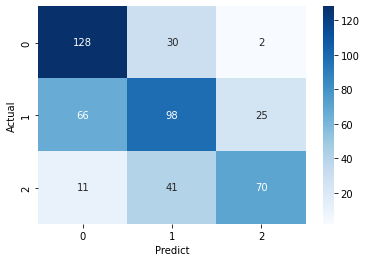

In [52]:
## classification_report
y_test = predictions.label_ids
preds_list = predicts_threshold
from sklearn.metrics import classification_report
clf_report = classification_report(y_test, preds_list)
print(clf_report)

# 오차행렬 생성
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(y_test, preds_list)

# 오차행렬 시각화
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [30]:
predictions

PredictionOutput(predictions=array([[0.0201702 , 0.00810584],
       [0.8221827 , 0.6473356 ],
       [0.861545  , 0.71183723],
       [0.76889575, 0.56911176],
       [0.7563527 , 0.5520428 ],
       [0.9795409 , 0.950017  ],
       [0.02081099, 0.00836663],
       [0.02024265, 0.00813532],
       [0.02019457, 0.00811576],
       [0.09039934, 0.0379562 ],
       [0.2927595 , 0.14113708],
       [0.9338768 , 0.8486389 ],
       [0.02028785, 0.00815371],
       [0.7271976 , 0.5141442 ],
       [0.91697085, 0.8142742 ],
       [0.6873844 , 0.46606755],
       [0.77251524, 0.5741272 ],
       [0.94340307, 0.8687192 ],
       [0.7634409 , 0.56162983],
       [0.9044221 , 0.7897627 ],
       [0.08394334, 0.03510097],
       [0.77507925, 0.57770485],
       [0.7565168 , 0.552263  ],
       [0.75580394, 0.5513067 ],
       [0.02361184, 0.00950892],
       [0.0201889 , 0.00811345],
       [0.76822835, 0.56819135],
       [0.97986   , 0.9507735 ],
       [0.693492  , 0.47318506],
       [0.9597

In [31]:
mae, mse = compute_mae_and_mse(y_test, preds_list)
print(mae)
print(mse)

tensor(0.3992)
tensor(0.4544)


# kaggle data

In [14]:
kaggle_hate_df = pd.read_csv(data_path+"kaggle_hate_test.txt", sep='\t')
tokenized_test_sentences = tokenizer(
                            list(kaggle_hate_df['comments']),
                            return_tensors="pt",
                            max_length=64,
                            padding=True,
                            truncation=True,
                            add_special_tokens=True)

In [15]:
test_label =  kaggle_hate_df["hate"].values
test_dataset = MyDataset(tokenized_test_sentences, test_label)

In [16]:
test_dataset.__len__()

974

In [17]:
from transformers import Trainer
model_path = 'C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_CORN_outputs/output/pytorch_model.bin'
model.load_state_dict(torch.load(model_path))
trainer = Trainer(
    model=model,                         # 학습하고자하는 🤗 Transformers model                # 위에서 정의한 Training Arguments
    eval_dataset=test_dataset           # 평가 데이터셋
)

In [18]:
predictions = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 974
  Batch size = 8
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [19]:
def corn_label_from_logits(logits):
    probas = torch.cumprod(logits, dim=1)
    probas = logits
    predict_levels = probas > 0.5
    predicted_labels = torch.sum(predict_levels, dim=1)
    return predicted_labels

In [20]:
preds_list = corn_label_from_logits(torch.tensor(predictions.predictions))

In [21]:
pred_df = pd.DataFrame(preds_list)
kaggle_df = pd.concat([kaggle_hate_df['comments'], pred_df[0]], axis=1)
kaggle_df.columns = ['comments', 'label']
kaggle_df

,comments,label
0,ㅋㅋㅋㅋ 그래도 조아해주는 팬들 많아서 좋겠다 ㅠㅠ 니들은 온유가 안만져줌 ㅠㅠ,1
1,둘다 넘 좋다~행복하세요,0
2,근데 만원이하는 현금결제만 하라고 써놓은집 우리나라에 엄청 많은데,1
3,원곡생각하나도 안나고 러블리즈 신곡나온줄!!! 너무 예쁘게 잘봤어요,0
4,장현승 얘도 참 이젠 짠하다...,0
...,...,...
969,대박 게스트... 꼭 봐야징~ 컨셉이 바뀌니깐 재미지넹,0
970,성형으로 다 뜯어고쳐놓고 예쁜척. 성형 전 니 얼굴 다 알고있다. 순자처럼 된장냄새...,2
971,분위기는 비슷하다만 전혀다른 전개던데 무슨ㅋㅋㄱ 우리나라사람들은 분위기만 비슷하면 ...,0
972,입에 손가릭이 10개 있으니 징그럽다,2


In [22]:
kaggle_df.to_csv("kaggle_hate_KcBERT_CORN.csv", index=False, encoding='utf-8')